# Evaluate Hawkears on test set
Tessa annotated 1000 randomly selected 3s clips from Localization Dataset for Ovenbird song presence/absence

"undertain" or clips with Ovenbird song only on <0.3s at the beginning/end excluded from the evaluation

I reviewed false-positives scoring over 0. There were 3: highest scoring one was actually mislabeled True Positive, one other was 'unsure' 

In [3]:
from opensoundscape import Audio, Spectrogram

import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt
def figsize(w,h):
    plt.rcParams['figure.figsize']=[w,h]
figsize(15,5) #for big visuals
%config InlineBackend.figure_format = 'retina'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from sklearn.metrics import (
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
)

import sys
sys.path.append("../../src/")
from preprocessor import mute_and_normalize

import bioacoustics_model_zoo as bmz

import opensoundscape as opso

In [4]:
root = Path("../../../random_1k_clips_test_set")

predict with hawkears

In [5]:
clips = pd.read_csv(root / "clips.csv")
clips["end_time"] = 3
clips = clips.set_index(["file", "start_time", "end_time"])

m = bmz.HawkEars()
preds = m.predict(clips, batch_size=64, num_workers=0, audio_root=root)

Downloaded completed: hgnet1.ckpt
Loading model from local checkpoint /Users/SML161/song25_oven_aiid/ovenbird-individual-recognition/scripts/1_create_evaluation_sets_from_localization/hgnet1.ckpt...
Downloaded completed: hgnet2.ckpt
Loading model from local checkpoint /Users/SML161/song25_oven_aiid/ovenbird-individual-recognition/scripts/1_create_evaluation_sets_from_localization/hgnet2.ckpt...
Downloaded completed: hgnet3.ckpt
Loading model from local checkpoint /Users/SML161/song25_oven_aiid/ovenbird-individual-recognition/scripts/1_create_evaluation_sets_from_localization/hgnet3.ckpt...
Downloaded completed: hgnet4.ckpt
Loading model from local checkpoint /Users/SML161/song25_oven_aiid/ovenbird-individual-recognition/scripts/1_create_evaluation_sets_from_localization/hgnet4.ckpt...
Downloaded completed: hgnet5.ckpt
Loading model from local checkpoint /Users/SML161/song25_oven_aiid/ovenbird-individual-recognition/scripts/1_create_evaluation_sets_from_localization/hgnet5.ckpt...


/Users/SML161/miniconda3/envs/opso0110/lib/python3.11/site-packages/opensoundscape/preprocess/preprocessors.py:512: DeprecationWarning: sample_shape argument is deprecated. Please use height, width, channels arguments instead. 
                The current behavior is to override height, width, channels with sample_shape 
                when sample_shape is not None.
                
  warnings.warn(
/Users/SML161/miniconda3/envs/opso0110/lib/python3.11/site-packages/opensoundscape/ml/cnn.py:599: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

  0%|          | 0/16 [00:00<?, ?it/s]

/Users/SML161/miniconda3/envs/opso0110/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [6]:
# load annotations
annots = pd.read_csv(root / "annots_v1.csv")
annots = clips.reset_index().join(annots["annotation"])

# convert label to boolean
annots["annotation"] = annots["annotation"] == "yes"

annots["hawkears_score"] = preds["Ovenbird"].values

# drop uncertain or edge detections
annots = annots[annots["annotation"] != "unknown"]

review high-scoring false positives

correct labels

In [7]:
fp = annots[(annots["annotation"] == False) & (annots["hawkears_score"] > 0)]
for i, row in fp.iterrows():
    print(f"{row.file} {row.start_time} {row.hawkears_score}")

    a = Audio.from_file(row.file, offset=row.start_time, duration=3)
    s = Spectrogram.from_audio(a)
    s.plot()
    a.show_widget()

SBT-6-83-16_0+1_0_20160623_050000_1422.wav 0 0.6368698477745056


/Users/SML161/miniconda3/envs/opso0110/lib/python3.11/site-packages/opensoundscape/audio.py:1465: UserWarning: Failed to load metadata: argument of type 'NoneType' is not iterable. Metadata will be None
  warnings.warn(f"Failed to load metadata: {exc}. Metadata will be None")


FileNotFoundError: [Errno 2] No such file or directory: 'SBT-6-83-16_0+1_0_20160623_050000_1422.wav'

re-load updated labels

In [ ]:
# load annotations
annots = pd.read_csv(root / "annots_v2.csv")
annots = clips.reset_index().join(annots["annotation"])

# convert label to boolean
annots["annotation"] = annots["annotation"] == "yes"
annots["hawkears_score"] = preds["Ovenbird"].values

# drop uncertain or edge detections
annots = annots[annots["annotation"] != "unknown"]

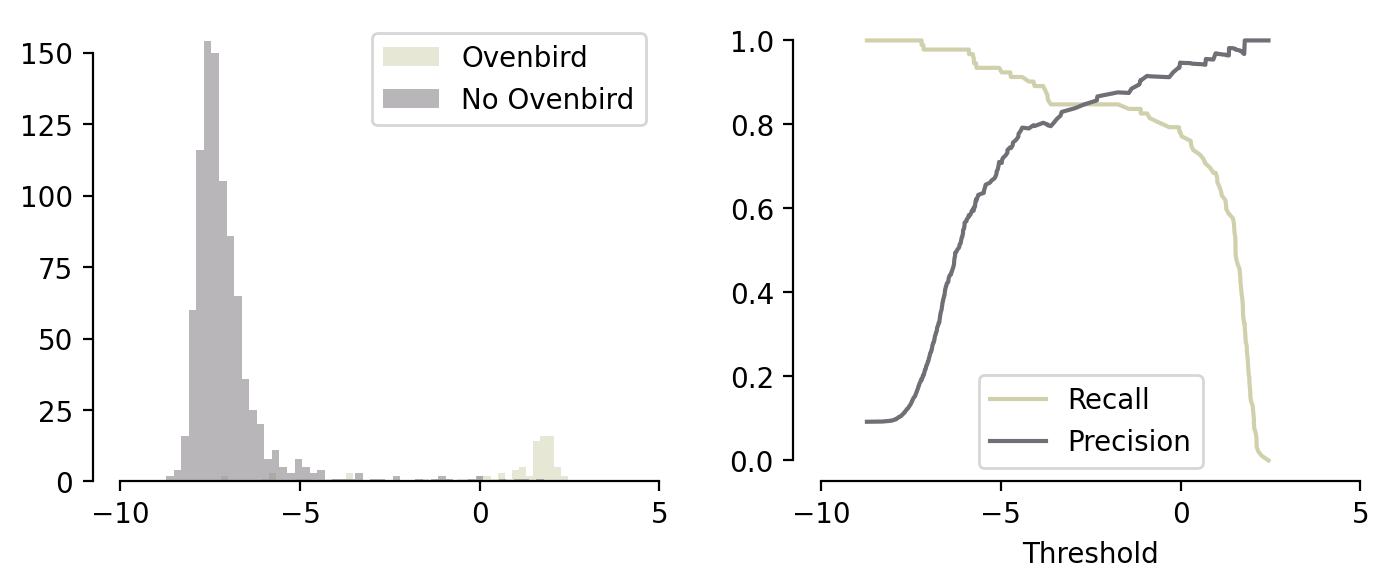

In [ ]:
figsize(8, 3)

import seaborn as sns

sns.set_palette(["#D0D1AC", "#726E75"])

fig, axs = plt.subplots(1, 2)

ax = axs[0]
pos_scores = annots[annots["annotation"] == True]["hawkears_score"]
neg_scores = annots[annots["annotation"] == False]["hawkears_score"]
ax.hist(pos_scores, bins=50, alpha=0.5, label="Ovenbird")
ax.hist(neg_scores, bins=50, alpha=0.5, label="No Ovenbird")
plt.legend()
sns.despine()
plt.xlabel("HawkEars score")
plt.xlim(-10, 4)
# trim x-axis line to end at end of numbers with gca
ax.set_xticks([-10, -5, 0, 5])
ax.spines["bottom"].set_bounds(-10, 5)
ax.spines["left"].set_position(("outward", 10))
ax.spines["left"].set_bounds(0, 150)
ax.legend()

# ax.spines['bottom'].set_position(('outward', 10))

p, r, t = precision_recall_curve(annots.annotation, annots.hawkears_score)
ax = axs[1]
ax.plot(t, r[1:])
ax.plot(t, p[1:])
ax.set_xlabel("Threshold")
ax.set_ylabel(None)
ax.legend(["Recall", "Precision"])

# horizontal spacing between subplots
plt.subplots_adjust(wspace=0.3)

# move the y axis left to give some space for the data
ax.spines["left"].set_position(("outward", 10))
ax.spines["left"].set_bounds(0, 1)
ax.set_xticks([-10, -5, 0, 5])

# ax.spines['bottom'].set_position(('outward', 10))

plt.savefig("../../figures/histogram_hawkears_species_classification.pdf")

measure performance metrics at threshold 1

In [62]:
threshold = 1
print(
    f"Precision: {precision_score(annots.annotation, annots.hawkears_score > threshold):0.3f}"
)
print(
    f"Recall: {recall_score(annots.annotation, annots.hawkears_score > threshold):0.3f}"
)
print(f"AUC: {roc_auc_score(annots.annotation, annots.hawkears_score):0.3f}")
print(f"AP: {average_precision_score(annots.annotation, annots.hawkears_score):0.3f}")

Precision: 0.969
Recall: 0.685
AUC: 0.985
AP: 0.926


In [68]:
threshold = -1
print(
    f"Precision: {precision_score(annots.annotation, annots.hawkears_score > threshold):0.3f}"
)
print(
    f"Recall: {recall_score(annots.annotation, annots.hawkears_score > threshold):0.3f}"
)
print(f"AUC: {roc_auc_score(annots.annotation, annots.hawkears_score):0.3f}")
print(f"AP: {average_precision_score(annots.annotation, annots.hawkears_score):0.3f}")

Precision: 0.905
Recall: 0.826
AUC: 0.985
AP: 0.926


In [ ]:
preds.drop(columns=["Ovenbird"]).max(axis=1)

file                                        start_time  end_time
SBT-6-76-1_0+1_0_20160622_080000_933.wav    0           3          -1.448037
SBT-6-76-47_0+1_0_20160624_070000_903.wav   0           3           0.732177
SBT-6-83-20_0+1_0_20160624_083000_1176.wav  0           3           1.504108
SBT-6-76-21_0+1_0_20160623_083000_1680.wav  0           3           1.799501
SBT-3-7-3_0+1_0_20160602_080000_687.wav     0           3           1.633667
                                                                      ...   
SBT-6-76-31_0+1_1_20160625_080000_1335.wav  0           3           0.986323
SBT-6-76-7_0+1_1_20160622_083000_624.wav    0           3           1.498165
SBT-6-76-11_0+1_0_20160623_080000_489.wav   0           3           1.645514
SBT-6-83-21_0+1_1_20160627_053000_642.wav   0           3           0.432362
SBT-6-76-6_0+1_0_20160621_063000_78.wav     0           3           1.812209
Length: 1000, dtype: float32

Measure recall when removing other clips with scores above 0.0

In [ ]:
annots["max_other_class_score"] = preds.drop(columns=["Ovenbird"]).max(axis=1).values
annots["oven_only"] = (annots["hawkears_score"] > 1) & (
    annots["max_other_class_score"] < 0
)
precision_score(annots.annotation, annots.oven_only), recall_score(
    annots.annotation, annots.oven_only
)

(0.9649122807017544, 0.5978260869565217)

Measure recall when muting 0-1 and 2-3 seconds

In [ ]:
m.preprocessor.insert_action(
    "mute_and_normalize",
    opso.Action(mute_and_normalize, is_augmentation=False),
    after_key="trim_audio",
)
preds2 = m.predict(clips, batch_size=64, num_workers=0, audio_root=root)
annots["hawkears_score_mute"] = preds2["Ovenbird"].values

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
annots["oven_strict"] = (
    (annots["hawkears_score"] > 1)
    & (annots["max_other_class_score"] < 0)
    & (annots["hawkears_score_mute"] > 0)
)
precision_score(annots.annotation, annots.oven_strict), recall_score(
    annots.annotation, annots.oven_strict
)

(1.0, 0.17391304347826086)